In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gensim
!pip install -U pip setuptools wheel
!pip install -U spacy
!spacy download en_core_web_lg
!pip install natasha

     |████████████████████████████████| 1.6MB 10.8MB/s 
Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (56.0.0)
Requirement already up-to-date: wheel in /usr/local/lib/python3.7/dist-packages (0.36.2)
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 12.8 MB 9.1 MB/s 
     |████████████████████████████████| 456 kB 45.0 MB/s 
     |████████████████████████████████| 42 kB 677 kB/s 
     |████████████████████████████████| 9.1 MB 39.7 MB/s 
     |██████

In [ ]:
import re
import gensim
import glob
import en_core_web_lg

Функции для обработки английских и испанских текстов

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won['’‘`]t", "will not", phrase)
    phrase = re.sub(r"can['’‘`]t", "can not", phrase)
    phrase = re.sub(r"ain['’‘`]t", "am not", phrase)

    # general
    phrase = re.sub(r"n['’‘`]t", " not", phrase)
    phrase = re.sub(r"['’‘`]re", " are", phrase)
    phrase = re.sub(r"['’‘`]s", " is", phrase)
    phrase = re.sub(r"['’‘`]d", " would", phrase)
    phrase = re.sub(r"['’‘`]ll", " will", phrase)
    phrase = re.sub(r"['’‘`]t", " not", phrase)
    phrase = re.sub(r"['’‘`]ve", " have", phrase)
    phrase = re.sub(r"['’‘`]m", " am", phrase)

    #phrase = re.sub('([.;!?])', r' \1 ', phrase)
    phrase = re.sub(r'[^\w.?!;]', ' ', phrase)
    phrase = re.sub(' +', ' ', phrase)
    sentences = re.split('([.;!?] *)', phrase)

    return ' '.join([i.capitalize() for i in  sentences])

In [ ]:
def prepare_english_text(input_path, output_path):
    nlp = en_core_web_lg.load(disable=['parser'])
    nlp.max_length = 5000000
    pos_dict = {'PROPN': 'PERSON1', 'PRON': 'PRON1', 'NUM': 'ORDINAL1'}
    file_name =  input_path.split('/')[-1]
    try:
        with open(input_path, 'r') as lit_text:
            raw_text = lit_text.read()
    except Exception as ex:
        return
    
    preprocessed_text = decontracted(raw_text)
    #preprocessed_list = gensim.utils.simple_preprocess(raw_text, min_len=1, max_len=100, deacc = True)
    #preprocessed_text  = ' '.join(preprocessed_list)
    
    nlp_doc = nlp(preprocessed_text)
    sorted_ents = sorted(nlp_doc.ents, key = lambda x: len(x), reverse =  True)


    for ent in sorted_ents:
        preprocessed_text = preprocessed_text.replace(' ' + ent.text + ' ', ' ' + ent.label_+ '1 ')
        if not ent.text.islower():
            preprocessed_text = preprocessed_text.replace(' ' + ent.text.lower() + ' ', ' ' + ent.label_+ '1 ')

    new_nlp_doc = nlp(preprocessed_text)

    with open(output_path + file_name, 'w') as prepared_text:
        for token in new_nlp_doc:
            if token.text[-1] != '1':
                if token.pos_ in pos_dict:
                    prepared_text.write(pos_dict[token.pos_])
                    prepared_text.write('\n')
                    
                elif token.pos_ != 'PUNCT':
                    prepared_text.write(token.lemma_.lower())
                    prepared_text.write('\n')

            else:
                prepared_text.write(token.text)
                prepared_text.write('\n')

Обработка английских текстов

In [ ]:
nlp = en_core_web_lg.load(disable=['parser'])
nlp.max_length = 5000000

In [ ]:
file_list = glob.glob('/content/drive/My Drive/ProjectSygma/texts/EnLit/*/*')

In [ ]:
len(file_list)

11057

In [ ]:
for path in file_list[i:]:
    if i % 500 == 0:
        print(i)
    i += 1
    prepare_english_text(path, '/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/', nlp)

10500
11000


In [ ]:
prepare_english_text('/content/drive/My Drive/ProjectSygma/texts/eng/anna_karenina_en_garnett.txt', '/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/', nlp)

In [ ]:
import glob

input_path = '/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/anna_karenina_en_garnett.txt'
dictionary_path = '/content/drive/My Drive/ProjectSygma/texts/Marina/english_dictionary.txt'
table_path = '/content/drive/My Drive/ProjectSygma/texts/Marina/en_sigma_v13.npy'

time_series = text_to_series(input_path, dictionary_path, table_path)
file_name =  input_path.split('/')[-1]
with open('/content/drive/My Drive/ProjectSygma/texts/time_series_eng/' + file_name, 'w') as file:
    for word in time_series:
        for comp in reversed(word):
            file.write(str(comp)+' ')
        file.write('\n')

In [ ]:
prepared_file_list = glob.glob('/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/*')
len(prepared_file_list)

11007

Обработка русских текстов


In [ ]:
def poem(text):
    lines = text.split('\n')
    if len(lines):
        not_poem_probability = sum([line[0].islower() for line in lines  if line]) / len(lines)
        return not_poem_probability < 0.3
    return False

In [ ]:
from natasha import (
    Segmenter, MorphVocab,
    NewsNERTagger,
    NewsEmbedding,
    NewsMorphTagger,    
    Doc
)

def prepare_russian_text(input_path, output_path):
    segmenter = Segmenter()
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb)
    ner_tagger = NewsNERTagger(emb)
    morph_vocab = MorphVocab()

    label_dict = {'NUM': '0', 'PRON': '1', 'PER': '2', 'LOC': '3', 'ORG': '4'}
    next_label_num = 5

    file_name =  input_path.split('/')[-1]


    print('here')

    with open(input_path, 'r',errors= 'ignore') as lit_text:
        try:
            raw_text = lit_text.read()
            
        except Exception as ex:
            return

    if poem(raw_text):
        raw_text = raw_text.replace('\n', '.\n')

    raw_text = re.sub(r'\d+', '0' , raw_text)


    doc = Doc(raw_text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)

    for span in reversed(doc.ner.spans):
        if span.type not in label_dict:
            label_dict[span.type] = str(next_label_num)
            next_label_num += 1
        #raw_text = " ".join((raw_text[:span.start], label_dict[span.type], raw_text[span.stop:]))
        raw_text = "".join((raw_text[:span.start], label_dict[span.type], raw_text[span.stop:]))

  
    doc = Doc(raw_text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    with open(output_path + file_name, 'w') as prepared_text:

        print(output_path + file_name)
       
        prev_num = False
        for token in doc.tokens:
            if token.pos == 'NUM' and not token.text.isdigit():
                if not prev_num:
                    prepared_text.write('0')
                    prepared_text.write('\n')
                    prev_num = True
                continue

            prev_num = False


            if token.pos == 'PRON':
                prepared_text.write('1')
                prepared_text.write('\n')
                continue
            
            if token.pos != 'PUNCT':
                try:
                    token.lemmatize(morph_vocab)
                    prepared_text.write(token.lemma.lower())
                    prepared_text.write('\n')
                except Exception as ex:
                    prepared_text.write(token.text.lower())
                    prepared_text.write('\n')

In [ ]:
file_list = glob.glob('/content/drive/My Drive/ProjectSygma/texts/RuLit/*/*')
len(file_list)

12697

In [ ]:
label_dict = {'NUM': '0', 'PRON': '1', 'PER': '2', 'LOC': '3', 'ORG': '4'}
next_label_num = 5
file_list = glob.glob('/content/drive/My Drive/ProjectSygma/texts/RuLit/*/*')
i = 0

for path in file_list[i:]:
    if i % 500 == 0:
        print(i)
    i+=1
    prepare_russian_text(path, '/content/drive/My Drive/ProjectSygma/texts/prep_rus/', label_dict, next_label_num)

In [ ]:
file_list = glob.glob('/content/drive/My Drive/ProjectSygma/texts/prep_rus/*')
file_list[408]

'/content/drive/My Drive/ProjectSygma/texts/prep_rus/51.4.4.25.txt'

Быстрая(?) обработка нового текста


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/ProjectSygma')
from plane_calc import *

In [ ]:
from bisect import bisect_left 
import numpy as np
def binary_search(a, x): 
    i = bisect_left(a, x) 
    if i != len(a) and a[i] == x: 
        return i 
    else: 
        return -1

def text_to_series(text_path, dictionary_path, table_path, lang):
    file_name = text_path.split('/')[-1]
    with open(dictionary_path, 'r') as my_dict:
        dictionary = my_dict.readlines()
    table = np.load(table_path)
    text_serie = []
    with open(text_path, 'r') as words:
        with open('/content/drive/My Drive/ProjectSygma/texts/time_series_'+lang+'/' + file_name, 'w') as file:
            for word in words:
                word_index = binary_search(dictionary, word)
                if word_index != -1:
                    word_vector = table[word_index]
                    text_serie.append(word_vector[::-1])
                    for word in reversed(word_vector):
                        file.write(str(word))
                    file.write('\n')       
    return text_serie

In [ ]:
import re
import pandas as pd
def raw_text_to_time_series(input_path, prepared_path, dictionary_path, table_path, pandas_path, lang):
    file_name = input_path.split('/')[-1]
    if lang == 'rus':
        prepare_russian_text(input_path, prepared_path)
    else:
        prepare_english_text(input_path, prepared_path)
    table = pd.read_csv(pandas_path, index_col = 0)

    ready_arr = text_to_series(prepared_path+file_name, dictionary_path, table_path, lang)

    print(ready_arr[:10])
    for (n, m) in [(3,5), (3,6), (3,7), (4,3),(4,4),(5,3),(6,2)]:
        table = table.append({'n':n, 'm':m, 'entropy':entropy_measure_m(ready_arr, n, m),
              'complexity':mpr_complexity_m(ready_arr, n, m), 'name': file_name, 'lang':lang}, ignore_index=True)

    table.to_csv(pandas_path)

In [ ]:
raw_text_to_time_series('/content/drive/My Drive/ProjectSygma/texts/eng/anna_karenina_en_machine.txt',
                        '/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/',
                        '/content/drive/My Drive/ProjectSygma/texts/Marina/english_dictionary.txt',
                        '/content/drive/My Drive/ProjectSygma/texts/Marina/en_sigma_v13.npy', 
                        '/content/drive/My Drive/ProjectSygma/ideal_table.csv', 'eng')

[array([ 0.03481767,  0.00507495,  0.00041518, -0.01485298, -0.004382  ,
       -0.00957851, -0.01703243,  0.01861394,  0.00468514,  0.01345207,
        0.00732705, -0.00344363,  0.0071368 ]), array([21.02488637,  0.38133443, -3.861606  , -1.03010638,  1.70182138,
       -1.03137649,  3.97172367, -1.45580654, -0.22751924, -1.1675408 ,
        0.40229719, -0.18397189,  0.24279918]), array([18.65970321,  4.14864059,  3.71194921, -2.82706259,  3.08576159,
        3.57056069,  0.30687046, -0.75346109, -0.26430892, -0.06773417,
        0.7575244 ,  0.19491425, -0.23207083]), array([ 2.48221093e+00, -5.09337013e-01, -4.87434160e-03, -4.71207014e-01,
       -2.56781395e-01, -8.93801033e-02,  3.65678068e-01, -3.73868803e-02,
        1.90855233e-03,  2.78101149e-02,  1.27734374e-01,  1.26105166e-01,
       -3.22887923e-01]), array([ 0.02531355,  0.00273184,  0.00890238, -0.00686345, -0.00077717,
       -0.01125544, -0.00694299, -0.00649281, -0.00086474,  0.00632169,
       -0.00050128, -0.01271

Разделение текста на фрагменты


In [ ]:
def make_pieces(file_path):
     with open(file_path, 'r') as file:
         text = file.read()
         piece_num = 0
         i = 0
         while i < len(text):
            text_piece = text[i:i+10000]
            j = 1
            while text_piece[-j] != ' ':
                j+=1

            i+=10000
            i-= j
            print(i, len(text))

            #with open(file_path[:-4]+'_piece'+str(piece_num)+'.txt', 'w') as output_file:
            #    output_file.write(text_piece[:-j])

            piece_num+= 1
            print(piece_num)



In [ ]:
 with open('/content/drive/My Drive/ProjectSygma/texts/rus/anna_karenina_ru_piece100.txt', 'r') as file:
         text = file.read()
text[:100]

' для него, когда они были тут и когда он мысленно переносился на их точку зрения, вдруг потеряло для'

In [ ]:
make_pieces('/content/drive/My Drive/ProjectSygma/texts/rus/anna_karenina_ru.txt')

9993 1707657
1
19991 1707657
2
29988 1707657
3
39985 1707657
4
49984 1707657
5
59976 1707657
6
69971 1707657
7
79970 1707657
8
89966 1707657
9
99964 1707657
10
109962 1707657
11
119957 1707657
12
129952 1707657
13
139950 1707657
14
149946 1707657
15
159943 1707657
16
169931 1707657
17
179926 1707657
18
189924 1707657
19
199921 1707657
20
209918 1707657
21
219913 1707657
22
229900 1707657
23
239894 1707657
24
249886 1707657
25
259880 1707657
26
269872 1707657
27
279860 1707657
28
289856 1707657
29
299848 1707657
30
309844 1707657
31
319840 1707657
32
329839 1707657
33
339835 1707657
34
349832 1707657
35
359825 1707657
36
369822 1707657
37
379816 1707657
38
389814 1707657
39
399809 1707657
40
409806 1707657
41
419802 1707657
42
429798 1707657
43
439796 1707657
44
449792 1707657
45
459789 1707657
46
469786 1707657
47
479785 1707657
48
489783 1707657
49
499775 1707657
50
509773 1707657
51
519768 1707657
52
529760 1707657
53
539751 1707657
54
549744 1707657
55
559740 1707657
56
569738 17076

Построение корпусов


In [ ]:
def make_corpus(input_path, output_file_path):
    i = 0
    file_list = glob.glob(input_path + '/*')
    with open(output_file_path, 'w') as output_file:
        for file in file_list:
            if i % 500 == 0:
                print(i)
            i+=1
            with open(file, 'r') as input_file:
                output_file.write(input_file.read().replace('\n', ' '))
                output_file.write('\n')

In [ ]:
make_corpus('/content/drive/My Drive/ProjectSygma/texts/new_prep_eng', '/content/drive/My Drive/ProjectSygma/texts/Marina/english_corpus.txt')

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000


In [ ]:
file_list = glob.glob('/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/*')

for file in file_list:
    with open(file, 'r') as text:
        full_text = text.read()
        if full_text.find('abenefit') != -1:
            print(file)

/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/Jennie_Baxter_Journalist(Fiction).txt
/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/Savage(Essays).txt
/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/Little_Journeys_Vol._11__Great_Businessmen(Non-Fiction).txt
/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/Little_Journeys_Vol._7__Eminent_Orators(Non-Fiction).txt
/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/Casey_Ryan(Fiction).txt
/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/Hocken_and_Hunken(Fiction).txt
/content/drive/My Drive/ProjectSygma/texts/new_prep_eng/The_Well(Short_Stories).txt


In [ ]:
upper_file_list[654]

'/content/drive/My Drive/ProjectSygma/texts/EnLitUpper/Edgar_Allan_Poe/To_Zante(Poetry).txt'

In [ ]:
make_corpus('/content/drive/My Drive/ProjectSygma/texts/prep_rus', '/content/drive/My Drive/ProjectSygma/texts/new_russian_corpus.txt')

Создание TF-IDF матрицы и словаря


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def make_table_and_dict(corpus_path, min_df, token_pattern = None, use_idf = True):
    with open(corpus_path, 'r') as corpus_file:
        if token_pattern:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df, token_pattern=token_pattern, use_idf=use_idf)
        else:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df)
        data_vectorized = vectorizer.fit_transform(corpus_file)
    return data_vectorized, vectorizer.get_feature_names()

In [ ]:
eng_data_vectorized, eng_dictionary = make_table_and_dict('/content/drive/My Drive/ProjectSygma/texts/Marina/english_corpus.txt', 3,  '[A-Za-z]+')
#with open('/content/drive/My Drive/ProjectSygma/texts/Marina/english_dictionary.txt', 'w') as output_file:
 #   for word in eng_dictionary:
  #      output_file.write(word)
   #     output_file.write('\n')

In [ ]:
eng_data_vectorized, eng_dictionary = make_table_and_dict('/content/drive/My Drive/ProjectSygma/texts/english_corpus.txt', 3,  '[A-Za-z]+')
#with open('/content/drive/My Drive/ProjectSygma/dictionaries/new_english_dictionary.txt', 'w') as output_file:
  #  for word in eng_dictionary:
   #    output_file.write(word)
    #   output_file.write('\n')

KeyboardInterrupt: ignored

In [ ]:
rus_data_vectorized, rus_dictionary = make_table_and_dict('/content/drive/My Drive/ProjectSygma/texts/Marina/Russian_Corpus.txt', 3,'[А-я0-9]+', True)
#with open('/content/drive/My Drive/ProjectSygma/dictionaries/new_russian_dictionary.txt', 'w') as output_file:
    #for word in rus_dictionary:
     #   output_file.write(word)
      #  output_file.write('\n')

SVD - разложение TF-IDF матрицы

In [ ]:
from scipy.sparse.linalg import svds
import numpy as np

In [ ]:
u, sigma, vt = svds(rus_data_transformed, 10)
vt[:,1]

array([ 0.03888029,  0.11760361,  0.15655315, -0.16311756, -0.07917239,
       -0.13868351,  0.07925649, -0.1744136 ,  0.29798788,  0.30166722])

In [ ]:
def create_tables(data_vectorized, k_range, name):
    for k in k_range:
        u, sigma, vt = svds(data_vectorized, k)
        with open('/content/drive/My Drive/ProjectSygma/texts/Marina/' + name + str(k) + '.npy', 'wb') as f:
            np.save(f, np.dot(np.diag(sigma), vt).T)

In [ ]:
def create_table(data_vectorized, k, name):
    u, sigma, vt = svds(data_vectorized, k)
    print(sigma)
    with open('/content/drive/My Drive/ProjectSygma/texts/Marina/' + name + str(k) + '.npy', 'wb') as f:
        np.save(f, np.dot(np.diag(sigma), vt).T)

In [ ]:
create_table(eng_data_vectorized, 13, 'en_sigma_v')

[ 4.33051911  4.64866739  4.76243313  5.02412885  5.50846611  5.76991304
  6.31218465  6.43659897  7.59954981  7.98900013  9.01831903 17.42487701
 82.00224458]


In [ ]:
table = np.load('/content/drive/My Drive/ProjectSygma/texts/Marina/rus_sigma_v_log13.npy')
table[25]

array([-2.51478260e-05, -2.17755646e-05, -4.47631486e-06,  1.09674622e-04,
       -1.16120426e-04, -1.87647304e-04,  2.90750039e-04,  5.62680468e-05,
        2.66307789e-05,  2.89740989e-04,  2.21361157e-04, -4.45194672e-04,
        1.55620547e-04])

In [ ]:
create_tables(rus_data_vectorized, range(1, 13), 'rus_sigma_v_')

In [ ]:
create_tables(eng_data_vectorized, range(1, 13), 'eng_sigma_v_')

In [ ]:
a = np.load('/content/drive/My Drive/ProjectSygma/new_tables/eng_sigma_v_10.npy')
a[2]

array([-3.12980961e-05,  8.44303447e-06, -2.94796719e-06,  1.24466272e-05,
       -1.21850228e-05,  1.49143333e-05,  6.91537815e-06, -1.68855133e-05,
       -1.25252895e-05, -5.01794812e-05])

Построение хаотического ряда по тексту

In [ ]:
series = text_to_series('/content/drive/My Drive/ProjectSygma/texts/prep_rus/101.3.1.txt', '/content/drive/My Drive/ProjectSygma/dictionaries/new_russian_dictionary.txt', 
              '/content/drive/My Drive/ProjectSygma/new_tables/rus_sigma_v_6.npy')

In [ ]:
str([1,2,3])

'[1, 2, 3]'

In [ ]:
series[:20]

[array([-0.00326908, -0.00364599,  0.01185516,  0.0135483 , -0.00701752,
         0.01830079]),
 array([ 0.00367738, -0.00017877, -0.00088702,  0.00360241, -0.00087294,
         0.00250802]),
 array([-0.00302516,  0.00937522,  0.00572599,  0.01721968, -0.01719312,
         0.06849896]),
 array([ 0.00149531, -0.00271911,  0.00427228,  0.00110616, -0.00035901,
         0.00847985]),
 array([ 1.48399118, -3.45168942, -3.09588605, -0.31069327,  5.01304979,
        13.82306462]),
 array([-1.45916909e-02,  9.02203330e-01, -9.80382188e-01,  1.91592789e+00,
         2.98914287e-03,  3.28243284e+00]),
 array([-0.04185052,  0.84742791, -0.15917721,  1.69202471,  0.30071478,
         3.50494975]),
 array([ 0.0002545 , -0.00012928,  0.00037372,  0.00020291,  0.00015757,
         0.00059133]),
 array([ 0.00802554,  0.01436353, -0.02305122,  0.04679932, -0.0025886 ,
         0.1483479 ]),
 array([0.01590533, 0.08433586, 0.03532131, 0.07743938, 0.11904759,
        0.64117842]),
 array([-0.02361238,  

In [ ]:
import math

def get_split_index_m(A):
    i = len(A) - 1
    while i > 0:
        if A[i] < A[i - 1]:
            i -= 1
        else:
            break
    return i - 1


def get_change_index_m(A, i):
    j = len(A) - 1
    while j >= i:
        if A[j] > A[i]:
            break
        else:
            j -= 1
    return j


def swap_m(A, i, j):
    A[i], A[j] = (A[j], A[i])


# reverse A[start:]
def reverse_m(A, start):
    left = start
    right = len(A) - 1
    while left < right:
        swap_m(A, left, right)
        left += 1
        right -= 1


def next_permutation_m(A, v):
    i = v - 1
    while i >= 0:
        split_index = get_split_index_m(A[i])
        # the Array is sorted in descreased order
        if split_index == -1:
            reverse_m(A[i], 0)
            i -= 1
        else:
            change_index = get_change_index_m(A[i], split_index)
            swap_m(A[i], split_index, change_index)
            reverse_m(A[i], split_index + 1)
            break


def factorial_m(n):
    ans = 1
    for i in range(2, n + 1):
        ans *= i
    return ans


def permutations_m(d, v):
    a = []
    for i in range(v):
        a.append([])
        for j in range(d):
            a[-1].append(j + 1)
    perm = dict()
    perm[str(a)] = 0
    for j in range(factorial_m(d) ** v - 1):
        next_permutation_m(a, v)
        perm[str(a)] = j + 1
    return perm


def s_max_m(d, v):
    return math.log(factorial_m(d) ** v)


def s_max_list_m(d, v):
    return [1 / (factorial_m(d) ** v)] * (factorial_m(d) ** v)


def p_m(arr, d, v): 
    pr = [0] * (factorial_m(d) ** v)
    permutation_dict = permutations_m(d, v)
    for i in range(d - 1, len(arr)):
        full_curr_perm = []
        for l in range(v):
            curr = []
            for j in range(i - d + 1, i + 1):
                curr.append([arr[j][l], len(curr) + 1])
            curr.sort()
            curr_perm = []
            for k in curr:
                curr_perm.append(k[1])
            full_curr_perm.append(curr_perm)
        pr[permutation_dict[str(full_curr_perm)]] += 1
    for i in range(len(pr)):
        pr[i] /= len(arr) - d + 1
    return pr


def s_m(pr):
    entropy = 0
    for i in range(len(pr)):
        if pr[i] != 0:
            entropy -= pr[i] * math.log(pr[i])
    return entropy

def q_0_calculation_m(d, v):
    pr = [0] * (factorial_m(d) ** v)
    pr[0] = 1
    b = s_max_list_m(d, v)
    b = [pr + b for pr, b in zip(pr, b)]
    b = [i * 0.5 for i in b]
    return 1 / (s_m(b) - s_m(pr) / 2 - s_max_m(d, v) / 2)

def q_j_m(arr, d, v):
    pr = p_m(arr, d, v)
    b = s_max_list_m(d, v)
    b = [pr + b for pr, b in zip(pr, b)]
    b = [i * 0.5 for i in b]
    return q_0_calculation_m(d, v) * (s_m(b) - s_m(pr) / 2 - s_max_m(d, v) / 2)

In [ ]:
def entropy_measure_m(arr, d, v):
    return s_m(p_m(arr, d, v))/s_max_m(d, v)

def mpr_complexity_m(arr, d, v):
    return q_j_m(arr, d, v) * entropy_measure_m(arr, d, v)

In [ ]:
entropy_measure_m(series, , 6)

0.7026488242520729

In [ ]:
mpr_complexity_m(series, 3, 6)

0.5010277718519315

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math


def s_b(N, p, m, n):
    if p != 0:
        return -(n * p * math.log(p) + (N - m - n) * (1 - p * n) / (N - m - n) * math.log((1 - p * n) / (N - m - n)))
    else:
        return math.log(N - m - n)

def s_b_1(N, p, m, n):
    return -(m / N * math.log(1 / N) + n * (p + 1 / N) / 2 * math.log((p + 1 / N) / 2) + (N - m - n) * ((1 - p * n) / (N - m - n) + 1 / N) / 2 * math.log((((1 - p * n) / (N - m - n)) + 1 / N) / 2))

def entropy_measure_b(N, p, m, n):
    return s_b(N, p, m, n) / math.log(N)

def q_0_calculation_b(N, p, m, n):
    return 1 / (s_b(N, 1 / 2 / N, 0, N - 1) - math.log(N) / 2)


def q_j_b(N, p, m, n):
    return q_0_calculation_b(N, p, m, n) * (s_b_1(N, p, m, n) - s_b(N, p, m, n) / 2 - math.log(N) / 2)

def mpr_complexity_b(N, p, m, n):
    return q_j_b(N, p, m, n) * entropy_measure_b(N, p, m, n)

def borders(N, x, y):
    i = 1;
    while (i * 100 < N):
        for n in range (N - i * 100, N - 1, i):
            plt.scatter(entropy_measure_b(N, 0, 0, n), mpr_complexity_b(N, 0, 0, n), c = "red")
        i *= 2
    for n in range (0, N - 1, i):
        plt.scatter(entropy_measure_b(N, 0, 0, n), mpr_complexity_b(N, 0, 0, n), c = "red")
    
    p = 0.01
    while p < 0.99:
        p += 0.01
        plt.scatter(entropy_measure_b(N, p, 0, 1), mpr_complexity_b(N, p, 0, 1), c="green")

    plt.scatter(x, y, c="blue")
    #plt.scatter(entropy_measure_b(N, 0.01, 0, 1), mpr_complexity_b(N, 0.01, 0, 1), c = "blue")
    plt.xlabel('entropy')
    plt.ylabel('mpr_complexity')
    #ax = plt.subplots()
    plt.title('n = 9')
    plt.show()

In [ ]:
series = np.array(series)
series.shape

(264030, 6)

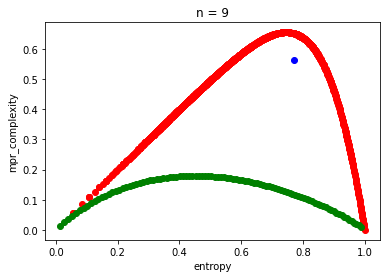

In [ ]:
borders(331776, entropy_measure_m(series[:,:4],4, 4), mpr_complexity_m(series[:,:4],4, 4))

In [ ]:
 entropy_measure_m(series[:,:4],4, 4)

0.7702056686307781

In [ ]:
mpr_complexity_m(series[:,:4],4, 4)

0.5640197724929857

In [ ]:
def compare_dicts(dictionary_path_1, dictionary_path_2):
    diffs = []
    with open(dictionary_path_1, 'r') as f_dict:
        with open(dictionary_path_2, 'r') as s_dict:
            f_dictionary = f_dict.read()
            s_dictionary = s_dict.read()
            for word in f_dictionary.split('\n'):
                if s_dictionary.find(word) == -1:
                    diffs.append(word)
    return diffs

a = compare_dicts('/content/drive/My Drive/ProjectSygma/texts/Marina/english_dictionary.txt', 
                  '/content/drive/My Drive/ProjectSygma/dictionaries/new_english_dictionary.txt'
              )
a[1000:]

['cajun',
 'calcilation',
 'calcining',
 'calculi',
 'calculinge',
 'caledonie',
 'calice',
 'calipee',
 'calked',
 'calkerlatin',
 'calkilated',
 'calkilatin',
 'calluna',
 'calorifere',
 'caloyer',
 'calypsos',
 'camarinam',
 'camball',
 'cambrics',
 'cambuskenneth',
 'cameliard',
 'camelotian',
 'camerera',
 'camion',
 'camouflaged',
 'campertogno',
 'camum',
 'canajian',
 'candaule',
 'candiote',
 'candore',
 'cankrie',
 'cannabina',
 'cannakin',
 'cannas',
 'canonesse',
 'canonnade',
 'canoodlin',
 'cantabrigiensi',
 'canterin',
 'cantering',
 'cantharidian',
 'cantium',
 'cantoned',
 'cantraip',
 'canvey',
 'capellae',
 'capellen',
 'caperer',
 'capiat',
 'capilli',
 'cappen',
 'cappy',
 'caprimulgus',
 'capten',
 'captif',
 'captyued',
 'carack',
 'carbondale',
 'carbonised',
 'carbuncled',
 'carcasse',
 'carcere',
 'cardinally',
 'careas',
 'careerin',
 'cariatide',
 'carimata',
 'carinthian',
 'carissimo',
 'carlina',
 'carnavalet',
 'carolingian',
 'carolled',
 'carolo',
 'ca

In [ ]:
len(a)

7304

In [ ]:
import pymystem3 
m = pymystem3.Mystem()
m.lemmatize('Бабочка взмахнула крыльями и улетела.\n Все взоры были направлены на неё.\n Взяв Марину за руку, Ваня пошёл гулять')

In [ ]:
b = compare_dicts('/content/drive/My Drive/ProjectSygma/dictionaries/english_dictionary.txt',
                  '/content/drive/My Drive/ProjectSygma/dictionaries/new_english_dictionary.txt')
b

['aaraaf',
 'aaronson',
 'abace',
 'abailard',
 'abajo',
 'abandonne',
 'abattu',
 'abazai',
 'abbondio',
 'abbotrule',
 'abducting',
 'abendessen',
 'aberfeldy',
 'abibis',
 'abiit',
 'abjectest',
 'aboad',
 'abominating',
 'abont',
 'aborder',
 'aboud',
 'abounded',
 'aboundingly',
 'aboveground',
 'aboyna',
 'abrahamus',
 'abreed',
 'abregge',
 'abreyde',
 'abrogated',
 'absentia',
 'absenting',
 'abstersive',
 'abuff',
 'abusu',
 'abutting',
 'abyla',
 'abyssmal',
 'acacias',
 'academia',
 'academicae',
 'acanthe',
 'accadian',
 'acclaiming',
 'acclimatized',
 'accorded',
 'accordent',
 'accumulated',
 'achaian',
 'achard',
 'acherontis',
 'achillis',
 'achmacalla',
 'acidulated',
 'acorse',
 'acquerir',
 'acquiesced',
 'activitie',
 'actresse',
 'actuated',
 'aculeatus',
 'acuman',
 'adalbert',
 'adamhill',
 'addlepated',
 'adelantado',
 'adeste',
 'adiantum',
 'adiise',
 'aditurae',
 'adjourning',
 'adjudged',
 'adkin',
 'admete',
 'administrador',
 'administre',
 'admonished',
 

In [ ]:
len(b)

9295

In [ ]:
with open('/content/drive/My Drive/ProjectSygma/texts/Marina/english_corpus.txt', 'r') as en_corpus:
    full_text =  en_corpus.read()
full_text.count('PRON1') 

2500030

In [ ]:
full_text.find('john') 

136694

In [ ]:
full_text[136650:136750]

'maybe a bit from the coachman PRON1 brother john alias master murray be about eleven when PRON1 come'